\# Detection of Large-Language Model (LLM) Generated Text

# Импорт библиотек

In [34]:
import pandas as pd
import numpy as np

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import tensorflow as tf


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

import matplotlib.pyplot as plt
import seaborn as sns


# Загружаем и предобрабртываем данные

In [35]:
data1=pd.read_csv('/content/train_v2_drcat_02.csv')
data2=pd.read_csv('/content/train_essays.csv')

In [36]:
# Выбор необходимых столбцов из первого набора данных и создание копии
train1_selected = data1[['text', 'label']].copy()

# Выбор необходимых столбцов из второго набора данных и переименование 'generated' в 'label'
train2_selected = data2[['text', 'generated']].rename(columns={'generated': 'label'}).copy()

# Объединение выбранных столбцов из обоих наборов данных
data = pd.concat([train1_selected, train2_selected], ignore_index=True)

# Вывод объединенных данных
print(data)

                                                    text  label
0      Phones\n\nModern humans today are always on th...      0
1      This essay will explain if drivers should or s...      0
2      Driving while the use of cellular devices\n\nT...      0
3      Phones & Driving\n\nDrivers should not be able...      0
4      Cell Phone Operation While Driving\n\nThe abil...      0
...                                                  ...    ...
46241  There has been a fuss about the Elector Colleg...      0
46242  Limiting car usage has many advantages. Such a...      0
46243  There's a new trend that has been developing f...      0
46244  As we all know cars are a big part of our soci...      0
46245  Cars have been around since the 1800's and hav...      0

[46246 rows x 2 columns]


In [37]:
# Удаляем дупликаты и нулевые значения
data.drop_duplicates(inplace=True)
data.dropna(inplace=True)

# Анализ данных в датасетах

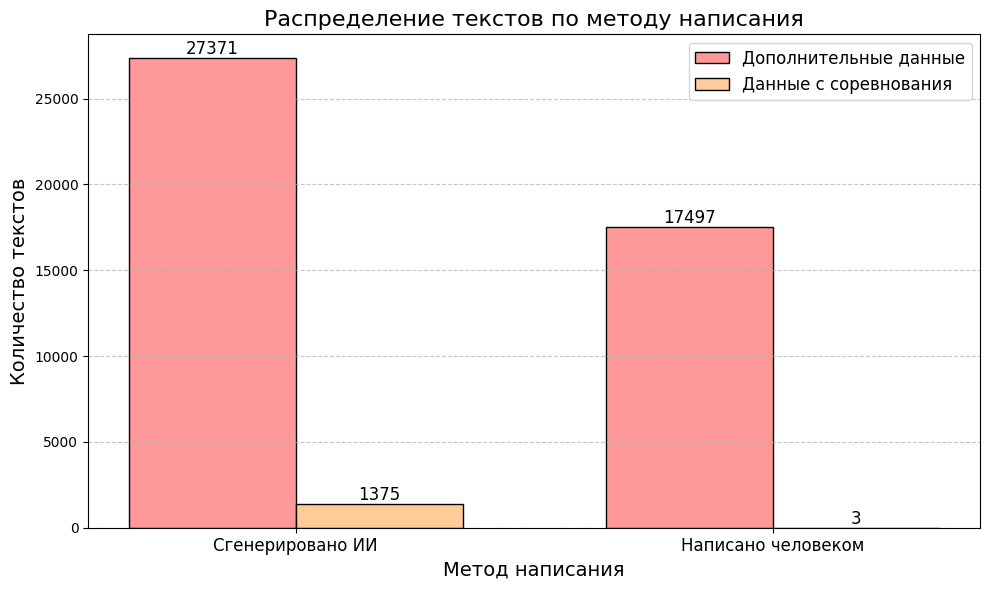

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Подсчет значений меток
data1_counts = data1['label'].value_counts().reset_index()
data2_counts = data2['generated'].value_counts().reset_index()

# Создание индексов для столбцов
index = np.arange(len(data1_counts))

# Значения для графиков
v1 = data1_counts['count'].values
v2 = data2_counts['count'].values

# Ширина столбцов
bw = 0.35

# Настройка графика
plt.figure(figsize=(10, 6))
plt.title('Распределение текстов по методу написания', fontsize=16)
plt.xlabel('Метод написания', fontsize=14)
plt.ylabel('Количество текстов', fontsize=14)

# Создание столбчатых графиков
bars1 = plt.bar(index, v1, bw, color='#FF9999', label='Дополнительные данные', edgecolor='black')
bars2 = plt.bar(index + bw, v2, bw, color='#FFCC99', label='Данные с соревнования', edgecolor='black')

# Настройка меток по оси X
plt.xticks(index + bw / 2, ['Сгенерировано ИИ', 'Написано человеком'], fontsize=12)
plt.legend(fontsize=12)

# Добавление значений на столбцы
def add_value_labels(bars):
    """Добавляет значения над столбцами."""
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2.0, height, f'{int(height)}', ha='center', va='bottom', fontsize=12)

add_value_labels(bars1)
add_value_labels(bars2)

# Установка сетки для лучшей читабельности
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Показ графика
plt.tight_layout()
plt.show()


# Векторизуем текст

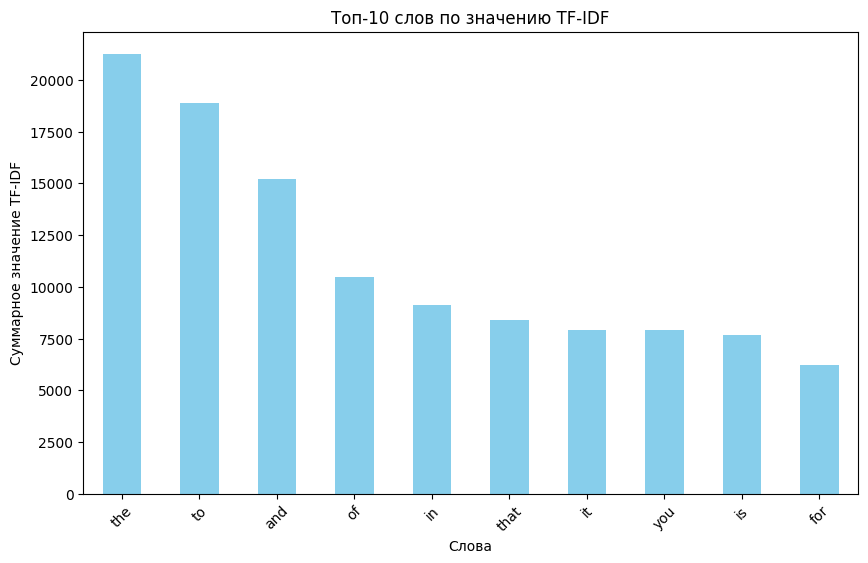

In [39]:
# Инициализация TF-IDF векторизатора
tfidf_vectorizer = TfidfVectorizer(max_features=10)  # Установим max_features для примера

# Токенизация и создание TF-IDF векторов для столбца 'text'
tfidf_vectors = tfidf_vectorizer.fit_transform(data['text'])

# Преобразование TF-IDF векторов в DataFrame
tfidf_df = pd.DataFrame(tfidf_vectors.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# Суммируем значения TF-IDF по всем документам для получения общего значения по каждому слову
tfidf_sum = tfidf_df.sum(axis=0)

# Сортируем значения по убыванию
tfidf_sorted = tfidf_sum.sort_values(ascending=False)

# Создание графика
plt.figure(figsize=(10, 6))
tfidf_sorted.head(10).plot(kind='bar', color='skyblue')
plt.title('Топ-10 слов по значению TF-IDF')
plt.xlabel('Слова')
plt.ylabel('Суммарное значение TF-IDF')
plt.xticks(rotation=45)
plt.show()

# Делим датасет на тренировочные и тестовые данные

In [40]:
X = tfidf_df.values
y = data['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Кодируем данные

In [41]:
# Кодирование целевых меток (0 и 1) с использованием LabelEncoder
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Архитекрура нейросети

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


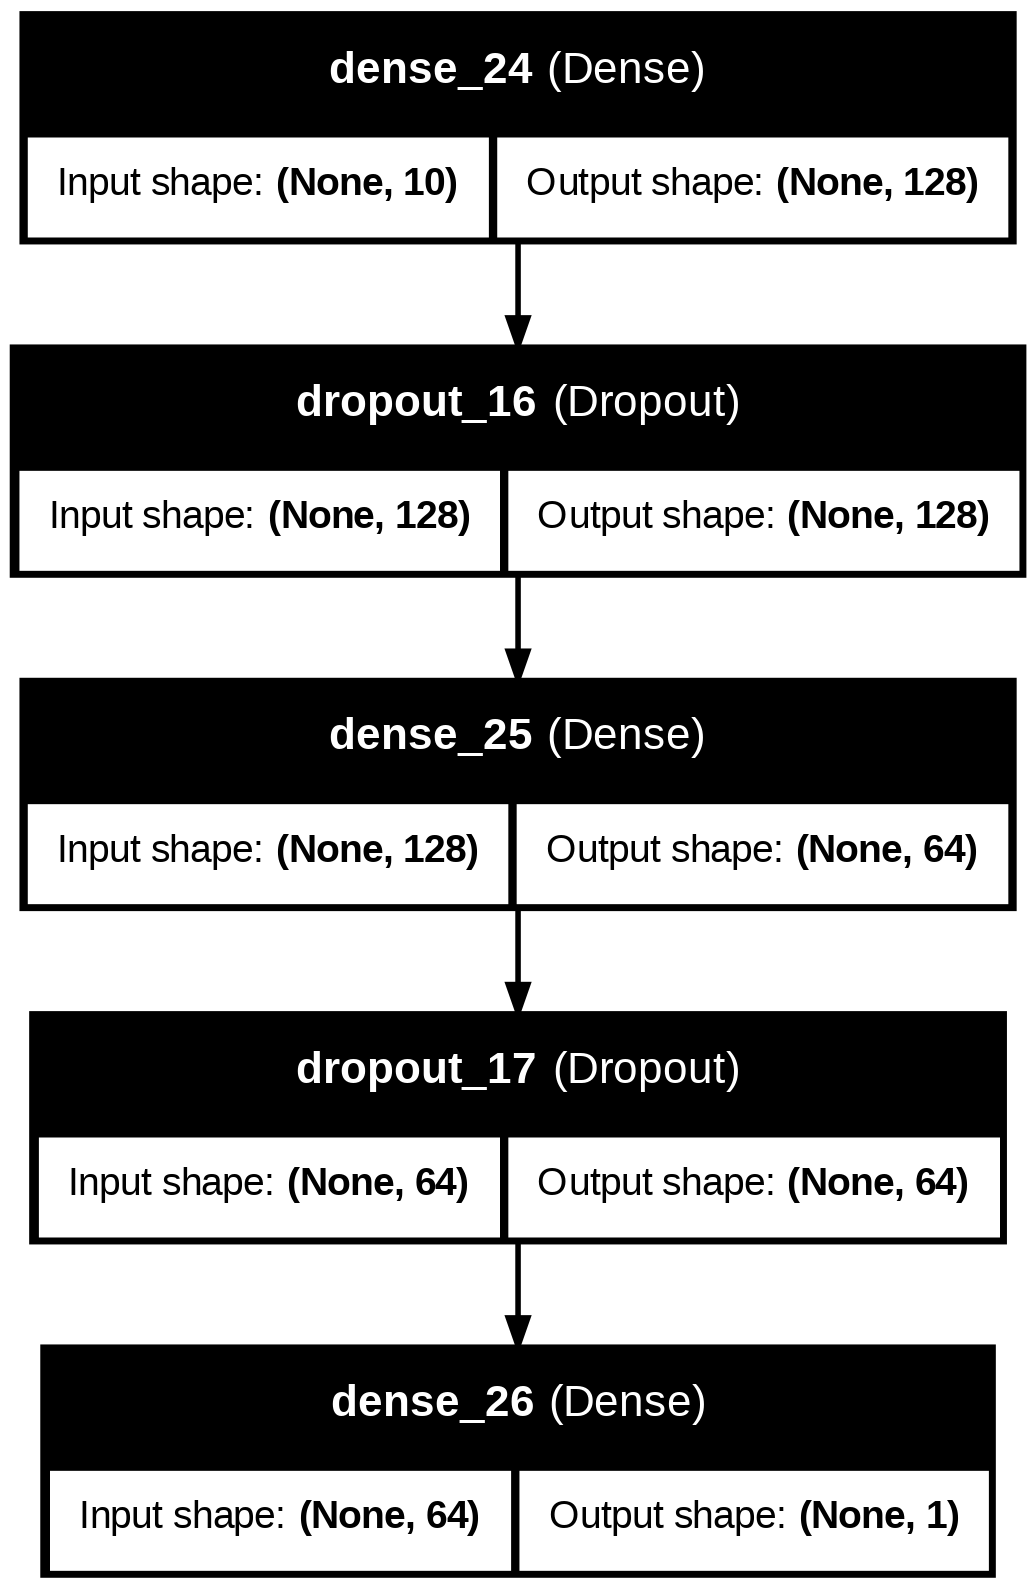

In [42]:
# Создаем модель для нейронной сети
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Визуализируем модель
plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)


# Обучение

In [43]:
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded), verbose=1)

Epoch 1/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7444 - loss: 0.5276 - val_accuracy: 0.7844 - val_loss: 0.4575
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7839 - loss: 0.4705 - val_accuracy: 0.8010 - val_loss: 0.4329
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7929 - loss: 0.4495 - val_accuracy: 0.8069 - val_loss: 0.4265
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7941 - loss: 0.4452 - val_accuracy: 0.8082 - val_loss: 0.4238
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.7996 - loss: 0.4358 - val_accuracy: 0.8082 - val_loss: 0.4201
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8056 - loss: 0.4338 - val_accuracy: 0.8131 - val_loss: 0.4189
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8051 - loss: 0.4312 - val_accuracy: 0.8144 - val_loss: 0.4128
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8072 - loss: 0.4280 - 

Epoch 1/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.7336 - loss: 0.5396 - val_accuracy: 0.7937 - val_loss: 0.4494
Epoch 2/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7816 - loss: 0.4674 - val_accuracy: 0.7973 - val_loss: 0.4353
Epoch 3/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7947 - loss: 0.4462 - val_accuracy: 0.8016 - val_loss: 0.4259
Epoch 4/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.7964 - loss: 0.4431 - val_accuracy: 0.8069 - val_loss: 0.4243
Epoch 5/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.7988 - loss: 0.4442 - val_accuracy: 0.8069 - val_loss: 0.4190
Epoch 6/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.7994 - loss: 0.4376 - val_accuracy: 0.8137 - val_loss: 0.4191
Epoch 7/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.8074 - loss: 0.4295 - val_accuracy: 0.8127 - val_loss: 0.4173
Epoch 8/10
1122/1122 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8036 - loss: 0.4297 - 

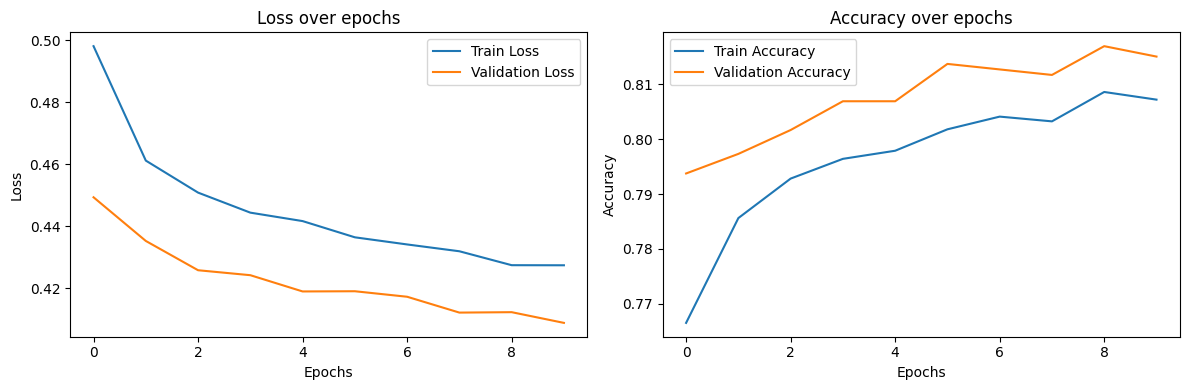

In [44]:
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from keras.utils import plot_model

# Создаем модель для нейронной сети
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Визуализируем модель
plot_model(model, to_file='model_visualization.png', show_shapes=True, show_layer_names=True)

# Обучаем модель и сохраняем историю
history = model.fit(X_train, y_train_encoded, epochs=10, batch_size=32, validation_data=(X_test, y_test_encoded), verbose=1)

# График потерь
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# График точности
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Показать графики
plt.tight_layout()
plt.show()

In [45]:
# Точность на тестовых данных
test_loss, test_accuracy = model.evaluate(X_test, y_test_encoded)
print(f'Test Accuracy: {test_accuracy:.4f}')

281/281 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8150 - loss: 0.4072
Test Accuracy: 0.8150


# Сохраняем модель

In [46]:
import pickle

with open('tfidf_tokenizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)

model.save('text_classification_model.h5')


# Usage Code

In [47]:
import pickle
from tensorflow.keras.models import load_model

# Загружаем токенизатор
with open('tfidf_tokenizer.pkl', 'rb') as f:
    tfidf_tokenizer = pickle.load(f)

# Загружаем модель
loaded_model = load_model('text_classification_model.h5')

# Функция предсказания
def predict_outcome(text):
    # Предобработка текста с использованием загруженного токенизатора
    text_features = tfidf_tokenizer.transform([text])

    # Преобразование текстовых признаков в плотный формат numpy массива
    text_features_dense = text_features.toarray()

    predictions = loaded_model.predict(text_features_dense)
    return predictions[0][0]

In [48]:
input_text = '''
Some people think that the only way to learn foreign languages is to start very early. Others believe that foreign languages can be learned at any age. In this essay I will address pluses and mines of learning foreign languages at an early age.
 On the one hand, since 4 years children talk with their parents very well. And if in family all speak on 2 languages, child will can speak on 2 languages too. It is the reason, because some people think that studying many languages is simply only at an early age. When I was younger my family often travel to different countries, when people speak in only English. And I learning to speak English to them. It was easy for me.
 On the other hand, many people move to another country. For them they must to learn another language. And they do it. That is an example of how people can learn another language at any age. I think, if people a person really wants to learn something, he can do it.
 In conclusion, somebody think that peoples can learn foreign languages at only an early age, but another think it can be done an any age. I think that everybody is right. All people can to learn foreign languages, but maybe it is easier to do it an early age.
'''


predicted_label = predict_outcome(input_text)
print("Predicted Label:", "{:.20f}".format(predicted_label))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted Label: 0.34909003973007202148


# Делаем предсказание на тестовых данных

In [49]:
test = pd.read_csv('/content/test_essays.csv')
test

,id,prompt_id,text
0,0000aaaa,2,Aaa bbb ccc.
1,1111bbbb,3,Bbb ccc ddd.
2,2222cccc,4,CCC ddd eee.


In [50]:
test['generated'] = test['text'].apply(predict_outcome)
submission = test[['id', 'generated']]
submission

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


,id,generated
0,0000aaaa,0.323409
1,1111bbbb,0.323409
2,2222cccc,0.323409


In [51]:
submission.to_csv('submission.csv', index=False)